# The FATE of FakeNews

## About the project

This project is a machine learning study based on the [fake news](https://www.kaggle.com/datasets/algord/fake-news/code) dataset and the interpertability of the machine learning models trained on said data. The goal of this work is to gain a deeper understanding of the chosen dataset and the WHYs regarding our model's "brain", in others words it's interpretability. My personal objective is to have a hands on approach in the field of FATE and better understand how to process data. 

Almost every data science paper talks about how we are living in the age of data abundance. We receive all kinds of information through our devices connected to the internet, such as: emails, weather forecasts, sleep metrics and the topic of my dataset, news. There is a sheer volume of news opinions from all sides made to fulfill every interest. While this can give us more insight, it can also provide us to information that may be misleading or outright false.

So, how can we tell if what we read is true? Well we could use machine learning to solve this issue. We should create a model based on a set of labeled data to tell whether a news article is real or fake. In doing so, we could also gain insights about the underlying patterns that writers use to gain more clicks or alter opinions by misleading their readers.

## Understanding our data

### Load the dataset, extract features and prepare data

Understanding the dataset is a crucial step in creating a good model.

First let's import a couple of packages and load in our dataset.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Render figures inside the notebook
%matplotlib inline

In [2]:
# Load dataset using pandas
original_dataset = pd.read_csv('https://raw.githubusercontent.com/nevernorbo/FateML_FakeNews/refs/heads/main/data/FakeNewsNet.csv')
original_dataset

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [3]:
# Let's see the features we are working with
original_dataset.columns

Index(['title', 'news_url', 'source_domain', 'tweet_num', 'real'], dtype='object')

Printing out the features of our dataset we can see that there are 5 features:
- `title`: the title of the article (string)  
- `news_url`: direct url to the article (string)
- `source_domain`: the domain the article is published on (string)
- `tweet_num`: the number of retweets for this article (number)
- `real`: a binary value representing whether the article is fake or real, where 0 is fake and 1 is real (number)

I am also interested in the number of distinct values in the `title` and `real` columns.  
I want to make sure that a single `title` only exists once in my dataset (they are most likely mirrors that I don't want my model to train on multiple times).  

I also want to make sure that the `real` feature is truly binary (just a sanity check).  
(These properties can also be easily checked by using the [data wrangler](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler) VSCode extension)

In [4]:
print('Number of datapoints: ', len(original_dataset))
print('---')
print('Number of unique titles: ', len(original_dataset['title'].unique()))
print('Number of non-unique titles: ', len(original_dataset['title'][original_dataset['title'].duplicated()]))
print('---')
print('Number of `real` values', len(original_dataset['real']))
print('Unique `real` values', original_dataset['real'].unique())

# Clean the dataset
original_dataset.drop_duplicates(subset='title', inplace=True)
original_dataset.dropna(subset='news_url', inplace=True)

original_dataset

Number of datapoints:  23196
---
Number of unique titles:  21724
Number of non-unique titles:  1472
---
Number of `real` values 23196
Unique `real` values [1 0]


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23190,See 'Love Actually' Sequel Clip for Red Nose D...,https://www.rollingstone.com/movies/movie-news...,www.rollingstone.com,0,1
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1


We should scrape the content corresponding to a `news_url` and create a dataset with that information included. To do this I created a `scraper.py` script in the scraper directory. Keep in mind that this will take a long time to run ~30 minutes for our 21k+ rows.

So I will upload a smaller dataset (FakeNewsNetContent.csv) containing only 320 rows with a 50:50 split between real and fake data. The reason behind this serious data reduction is that only 160 fake websites remained after I cleaned the dataset from articles without any content. This is probably due to the dataset being old and most fake news links are dead, which in itself is an interesting fact. This new dataset was also too large and the ratio of real to fake data was immense, causing class imbalance which would in turn cause the model to be biased towards the majority class, incorrecly labeling more articles as real.

The content of an article will be stored as another feature by name `article_content` (string).

In [5]:
# Load in our content complete dataset
content_dataset = pd.read_csv('https://raw.githubusercontent.com/nevernorbo/FateML_FakeNews/refs/heads/main/data/FakeNewsNetContent.csv')
content_dataset

,title,news_url,source_domain,tweet_num,real,article_content
0,Trump to Jimmy Fallon: 'Be a man.' Late-night ...,https://www.nbcnews.com/politics/donald-trump/...,www.nbcnews.com,20,1,WASHINGTON — President Donald Trump is telling...
1,Moana Hits Netflix Today So Let’s Celebrate Wi...,https://medium.com/@AndreAguirre25111NTZ/moana...,medium.com,58,1,"Moana Hits Netflix Today, So Let’s Celebrate W..."
2,How to get Meghan Markle-worthy lips in 3 easy...,https://www.redonline.co.uk/beauty/10-best/a23...,www.redonline.co.uk,74,1,Meghan Markle has inspired many a trend since ...
3,James Van Der Beek Reveals He's Been Sexually ...,https://www.huffingtonpost.com/entry/james-van...,www.huffingtonpost.com,74,1,LOADING ERROR LOADING\n\nThe wave of women com...
4,Melrose Place Star Josie Bissett Is Married! S...,https://www.brides.com/story/melrose-place-sta...,www.brides.com,31,1,"Kate Hudson Wants to Be ""Engaged Forever"" for ..."
...,...,...,...,...,...,...
315,Attorney General Sessions Statement on Recusal,https://www.justice.gov/opa/pr/attorney-genera...,www.justice.gov,110,0,Attorney General Jeff Sessions today issued th...
316,Obama Goes To G20 Summit,https://web.archive.org/web/20170806200608/htt...,web.archive.org,46,0,62.1k SHARES Share\n\nObama is a shadow presid...
317,CNN To Permanently Close Its Doors As Ratings ...,https://yournewswire.com/cnn-ratings-plunge-30...,yournewswire.com,122,0,Jordan Poole +300 To Win NBA Sixth Man Of The ...
318,United Airlines Flight Attendant Slaps Crying ...,http://now8news.com/united-airlines-flight-att...,now8news.com,23,0,"During a flight from New York City to Chicago,..."


As I said before I have already cleaned this dataset, because the scaper couldn't find the content in all cases, so there are a lot of rows with no value and some had missing content.
After cleanup we are left with 320 datapoints of which half is fake and half is real.

In [6]:
print(content_dataset.shape[0])
print(content_dataset[content_dataset['real'] == 1].shape[0]) # Real
print(content_dataset[content_dataset['real'] == 0].shape[0]) # Fake

320
160
160


### Data visualization

Let's continue by visualizing the real to fake class distribution of the original dataset which has more data.

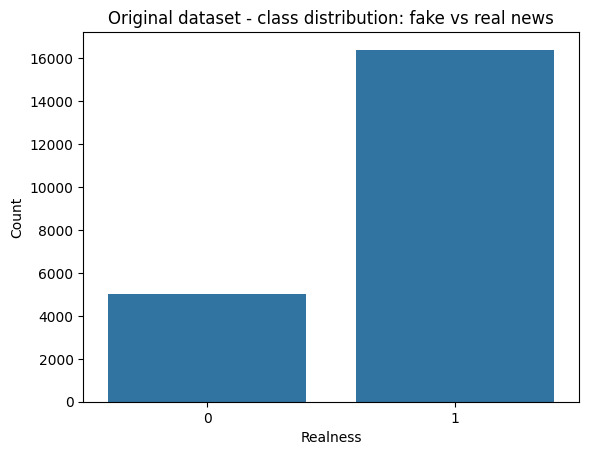

Real news:  16401
Fake news:  4996
Ratio:  3.282826261008807


In [7]:
sns.countplot(data=original_dataset, x='real')
plt.title('Original dataset - class distribution: fake vs real news')
plt.xlabel('Realness')
plt.ylabel('Count')
plt.show()

real_count = len(original_dataset[original_dataset['real'] == 1])
fake_count = len(original_dataset[original_dataset['real'] == 0])
print("Real news: ", real_count)
print("Fake news: ", fake_count)
print("Ratio: ", real_count / fake_count)

One might be interested in the distribution of different sources. 

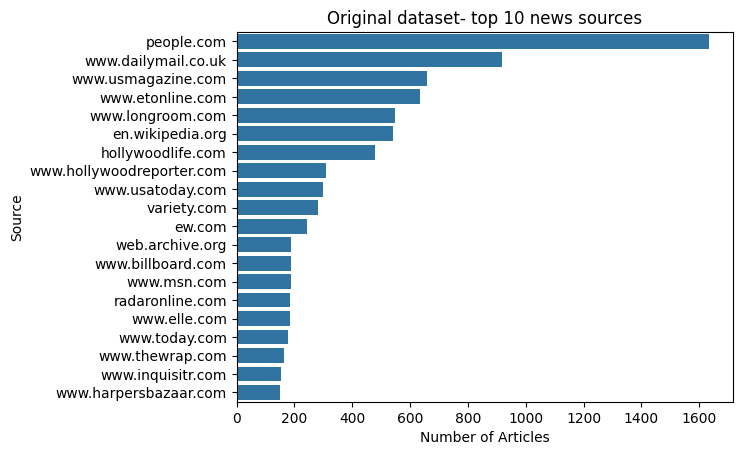

In [8]:
top_sources = original_dataset['source_domain'].value_counts().head(20)
sns.barplot(x=top_sources.values, y=top_sources.index)

plt.title('Original dataset- top 10 news sources')
plt.xlabel('Number of Articles')
plt.ylabel('Source')
plt.show()

Next let's generate separate word clouds for fake and real news titles and contents. This reveals the most frequent words and highlights language differences between fake and real news.

The most notable observation here is that fake news really loves to use a couple of celebrity names and repeat them ad nauseam. 

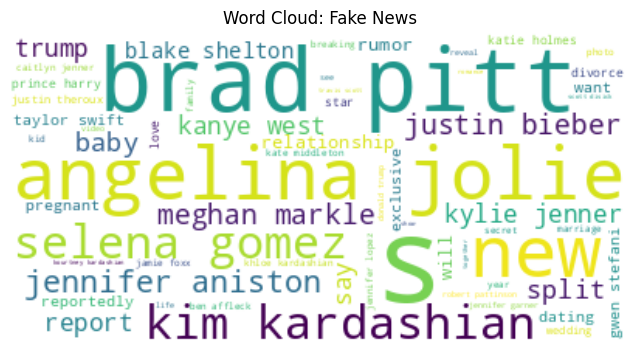

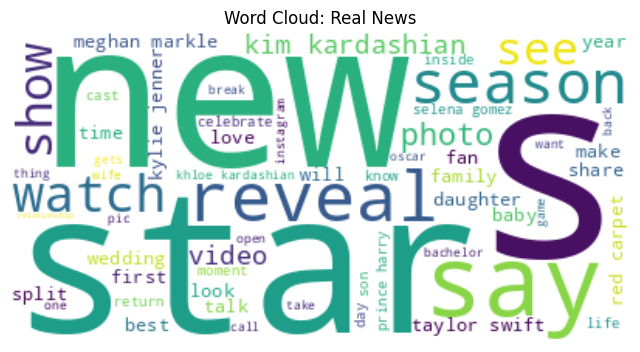

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for fake news
fake_text = ' '.join(original_dataset[original_dataset['real'] == 0]['title']).lower()
fake_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(fake_text)

plt.figure(figsize=(8,8))
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Fake News')
plt.show()

# Word cloud for real news
real_text = ' '.join(original_dataset[original_dataset['real'] == 1]['title']).lower()
real_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(real_text)

plt.figure(figsize=(8,8))
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Real News')
plt.show()

On these wordclouds we could actually plot the values from the `article_content` feature as well.

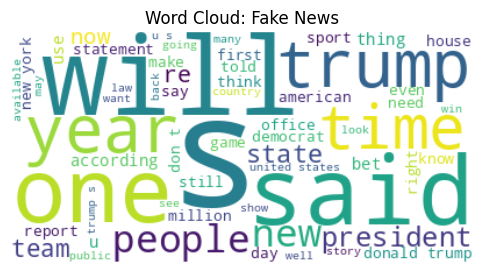

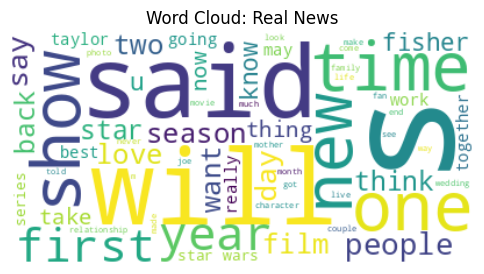

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for fake news 
fake_text = ' '.join(content_dataset[content_dataset['real'] == 0]['article_content']).lower()
fake_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(fake_text)

plt.figure(figsize=(6,6))
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Fake News')
plt.show()

# Word cloud for real news
real_text = ' '.join(content_dataset[content_dataset['real'] == 1]['article_content']).lower()
real_cloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60).generate(real_text)

plt.figure(figsize=(6,6))
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Real News')
plt.show()

## Fitting the models

In this section I am going to train multiple models with the dividing difference being the dataset that they are trained on:
- Larger dataset without article content: one Multinomial Naive Bayes classifier and a logistic regression model to determine fakeness by article titles
- Smaller dataset with article content: one Multinomial Naive Bayes classifier to determine fakeness using the article content 

### Dataset without article content

In this case we want our model to learn the `title` datapoints so it can predict whether the data was real or not. To do this we will create our train (~70%), development (10%) and test (20%) splits. 

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(original_dataset, train_size=0.8, random_state=0)
train, dev = train_test_split(train, train_size=int(len(original_dataset)*0.7), random_state=0)
train_x, train_y, test_x, test_y = train['title'], train['real'], test['title'], test['real']
dev_x, dev_y = dev['title'], dev['real']

len(train), len(dev), len(test)

(14977, 2140, 4280)

Because the `title` data is text, we cannot pass this directly to the model. These texts need to be vectorized. To do this I will use the TF-IDF (term frequency-inverse document frequency) method, which will take the strings and turn them into a numerical feature vector on which a model can be fitted.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the title feature
title_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
train_x_vectorized = title_vectorizer.fit_transform(train_x)
dev_x_vectorized = title_vectorizer.transform(dev_x)
test_x_vectorized = title_vectorizer.transform(test_x)

# Print the indices of each feature name
title_vectorizer.vocabulary_

{'emergency': 4462,
 'sections': 11649,
 'days': 3543,
 'long': 7908,
 'labor': 7490,
 'breech': 1893,
 'babies': 1127,
 'complicated': 2919,
 'duggar': 4240,
 'births': 1559,
 'angelina': 750,
 'jolie': 7088,
 'misses': 8651,
 'connection': 2998,
 'brad': 1830,
 'pitt': 9916,
 'used': 13968,
 'world': 14562,
 'king': 7359,
 'peppy': 9738,
 'new': 9063,
 'pic': 9848,
 'katie': 7228,
 'holmes': 6352,
 'jamie': 6949,
 'foxx': 5292,
 'date': 3523,
 'breakup': 1880,
 'ignites': 6577,
 'criticism': 3302,
 'kris': 7449,
 'jenner': 7009,
 'says': 11505,
 'khloé': 7317,
 'kardashian': 7205,
 'true': 13678,
 'thompson': 13297,
 'home': 6357,
 'la': 7481,
 'tristan': 13646,
 'set': 11737,
 'grace': 5751,
 'tv': 13736,
 'revival': 11051,
 'actually': 440,
 'works': 14560,
 'favorite': 4928,
 '90s': 306,
 'singers': 12040,
 'doing': 4049,
 'today': 13423,
 'jack': 6919,
 'brooksbank': 1978,
 'princess': 10258,
 'eugenie': 4643,
 'fiance': 5015,
 'meghan': 8436,
 'markle': 8242,
 'briefcase': 1926,

Now that we have our vectorized feature let's create the model. 

A Multinomial Naive Bayes classifier models the frequency of words as counts and assumes each feature or word is multinomially distributed. MNB is widely used for tasks like classifying documents based on word frequencies like in spam email detection [(GFG)](https://www.geeksforgeeks.org/multinomial-naive-bayes/). 

In [13]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Class for the Multinomial Naive Bayes functions
class MNB:
    # Create the MNB with the alpha parameter
    def __init__(self, alpha):
        self.mnb = MultinomialNB(alpha=alpha)
    
    # Train the model
    def train_mnb(self, train_x, train_y):
        self.mnb.fit(train_x, train_y)

    # Evaluate the model and save the predicted result
    def evaluate_mnb(self, predict_x):
        self.predictions = self.mnb.predict(predict_x)

    # Calculate classification report for the object
    def calculate_classification_report(self, correct_y):
        self.report = classification_report(correct_y, self.predictions, target_names=['fake', 'real'])
    
    def get_classification_report(self):
        return self.report

In [14]:
title_mnb = MNB(0.5)
title_mnb.train_mnb(train_x_vectorized, train_y)
title_mnb.evaluate_mnb(dev_x_vectorized)
title_mnb.calculate_classification_report(dev_y)

print(title_mnb.get_classification_report())

              precision    recall  f1-score   support

        fake       0.82      0.35      0.49       505
        real       0.83      0.98      0.90      1635

    accuracy                           0.83      2140
   macro avg       0.82      0.66      0.70      2140
weighted avg       0.83      0.83      0.80      2140



After evaluating our model we can see that the accuracy score is quite high... but what does this mean in our model? Remember that this dataset is imbalanced (3 real : 1 fake), meaning that there are a lot more 'real' titles in here which in turn makes this metric pretty much useless to us. For heavily imbalanced datasets, where one class appears very rarely, say 1% of the time, a model that predicts negative 100% of the time would score 99% on accuracy, despite being useless. Instead of accuracy we should optimize for precision or recall. In our case precision scores are high for both classes, but the recall score, meaning correctly classified positives for detecting fakes is atrocious, it only classifies 35% of fake news as fake.

When optimizing for precision and recall it's really up to us to figure out what we want to do in case of our model. Generally (!) these two parameters usually express an inverse relationship, meaning that when one increases the other decreases. So there is a trade-off between the two values. In our case this could mean that the precision is only high because it's being evaluated on a class with low recall. This big difference between the two values can be easily seen on the mediocre F1-score of the fake class. Now because I want to give better answers to what fraction of news are labelled as fake by this model, in this case I would optimize for recall at the potential cost of precision, while trying to get the F1-score closer to 1. (But later on we'll see how the scraped, balanced dataset model performs)


I wanted to fit another model to compare the differences between the two, so I also fitted a logistic regression model on this dataset. The results are very similar, maybe a bit worse in some cases than the previous MNB one.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and fit logistic regression model
regression_model = LogisticRegression(max_iter=100)
regression_model.fit(train_x_vectorized, train_y)

# Evaluate on development set
dev_pred = regression_model.predict(dev_x_vectorized)

report = classification_report(dev_y, dev_pred, target_names=['fake', 'real'])

print(report)

              precision    recall  f1-score   support

        fake       0.79      0.40      0.53       505
        real       0.84      0.97      0.90      1635

    accuracy                           0.83      2140
   macro avg       0.81      0.68      0.71      2140
weighted avg       0.83      0.83      0.81      2140



### Dataset with article content

In [16]:
# Load the dataset with the article content feature included (in case you didn't do it already in the previous section)
content_dataset = pd.read_csv('https://raw.githubusercontent.com/nevernorbo/FateML_FakeNews/refs/heads/main/data/FakeNewsNetContent.csv')
content_dataset

,title,news_url,source_domain,tweet_num,real,article_content
0,Trump to Jimmy Fallon: 'Be a man.' Late-night ...,https://www.nbcnews.com/politics/donald-trump/...,www.nbcnews.com,20,1,WASHINGTON — President Donald Trump is telling...
1,Moana Hits Netflix Today So Let’s Celebrate Wi...,https://medium.com/@AndreAguirre25111NTZ/moana...,medium.com,58,1,"Moana Hits Netflix Today, So Let’s Celebrate W..."
2,How to get Meghan Markle-worthy lips in 3 easy...,https://www.redonline.co.uk/beauty/10-best/a23...,www.redonline.co.uk,74,1,Meghan Markle has inspired many a trend since ...
3,James Van Der Beek Reveals He's Been Sexually ...,https://www.huffingtonpost.com/entry/james-van...,www.huffingtonpost.com,74,1,LOADING ERROR LOADING\n\nThe wave of women com...
4,Melrose Place Star Josie Bissett Is Married! S...,https://www.brides.com/story/melrose-place-sta...,www.brides.com,31,1,"Kate Hudson Wants to Be ""Engaged Forever"" for ..."
...,...,...,...,...,...,...
315,Attorney General Sessions Statement on Recusal,https://www.justice.gov/opa/pr/attorney-genera...,www.justice.gov,110,0,Attorney General Jeff Sessions today issued th...
316,Obama Goes To G20 Summit,https://web.archive.org/web/20170806200608/htt...,web.archive.org,46,0,62.1k SHARES Share\n\nObama is a shadow presid...
317,CNN To Permanently Close Its Doors As Ratings ...,https://yournewswire.com/cnn-ratings-plunge-30...,yournewswire.com,122,0,Jordan Poole +300 To Win NBA Sixth Man Of The ...
318,United Airlines Flight Attendant Slaps Crying ...,http://now8news.com/united-airlines-flight-att...,now8news.com,23,0,"During a flight from New York City to Chicago,..."


The procedure is the same as last time:
- Create the train (70%), test (30%) splits
  - This time with the `article_content` instead of the `title`
  - And I won't create a dev split now, because there are very few datapoints
- Vectorize the content
- Train a MNB model on the train set
- Test the model using the test set

In [17]:
# Create splits
content_train, content_test = train_test_split(content_dataset, train_size=0.7, random_state=0)
content_train_x, content_train_y, content_test_x, content_test_y = content_train['article_content'], content_train['real'], content_test['article_content'], content_test['real']

len(content_train), len(test)

(224, 4280)

In [18]:
# Vectorize the content feature
content_vectorizer = TfidfVectorizer(stop_words='english')
content_train_x_vectorized = content_vectorizer.fit_transform(content_train_x)
content_test_x_vectorized = content_vectorizer.transform(content_test_x)

In [19]:
# Fit Multinomial Naive Bayes classifier
content_mnb = MNB(0.5)
content_mnb.train_mnb(content_train_x_vectorized, content_train_y)
content_mnb.evaluate_mnb(content_test_x_vectorized)
content_mnb.calculate_classification_report(content_test_y)

print(content_mnb.get_classification_report())

              precision    recall  f1-score   support

        fake       0.93      0.86      0.89        43
        real       0.89      0.94      0.92        53

    accuracy                           0.91        96
   macro avg       0.91      0.90      0.90        96
weighted avg       0.91      0.91      0.91        96



We can see that most of our classification metrics are better. With fewer samples the metrics may not generalize well to larger datasets. It's really a shame that there are only this few datapoints left. I tried to offset this by not making a dev set. The model achieves very similar precision, recall, and F1-scores for both classes, indicating that it does not strongly favor one class over the other. This is a good sign, especially compared to the previous title only model, which struggled with recall for the fake class.

## Model interpretation

In the previous section there were already some inline interpretations regarding model metrics and briefly explored the inner workings of my models. In this section I will use local and global model-agnostic interpretation methods to interpret both of my MNB models.

### Local methods

#### Local Interpretable Model-agnostic Explanation (LIME)

In [20]:
from sklearn.pipeline import make_pipeline

# Create a pipline for the title model
title_pipeline = make_pipeline(title_vectorizer, title_mnb.mnb)
title_pipeline.predict_proba(dev_x)

array([[0.3244083 , 0.6755917 ],
       [0.02911137, 0.97088863],
       [0.14919695, 0.85080305],
       ...,
       [0.75400376, 0.24599624],
       [0.00699433, 0.99300567],
       [0.11318254, 0.88681746]], shape=(2140, 2))

In [21]:
from lime.lime_text import LimeTextExplainer

class_names = ['fake', 'real']

# Pick a document id
document_id = 15

# Create a lime text explainer
explainer = LimeTextExplainer(class_names=class_names)

# Explain our chosen document using the explainer
title_explanations = explainer.explain_instance(dev_x.iloc[document_id], title_pipeline.predict_proba, num_features=8)

print('Title: ', dev_x.iloc[document_id])
print('Probability that the article is real =', title_pipeline.predict_proba([dev_x.iloc[document_id]])[0, 1])
print('True class: %s' % class_names[dev_y.iloc[document_id]])

Title:  BREAKING: 60 People Just Found Dead In Ohio
Probability that the article is real = 0.6143360502575329
True class: fake


As a result we got a 61% probability of the article being real, however that is not the case. Let's look at why that might be.

In [22]:
# Print the local explanation values as a list
title_explanations.as_list()

[(np.str_('BREAKING'), -0.19654130530137587),
 (np.str_('Ohio'), -0.08111016531612102),
 (np.str_('Dead'), 0.08079934839413519),
 (np.str_('60'), 0.05502442656121232),
 (np.str_('People'), 0.04053537601624063),
 (np.str_('Just'), 0.01379568913197162),
 (np.str_('In'), -0.0007470854857421948),
 (np.str_('Found'), -0.0003301247231975471)]

Here negative values mean that the model has learned to associate these words with an article being fake, and positive values with it being real.  

We can also plot this result and see the explanation more clearly.

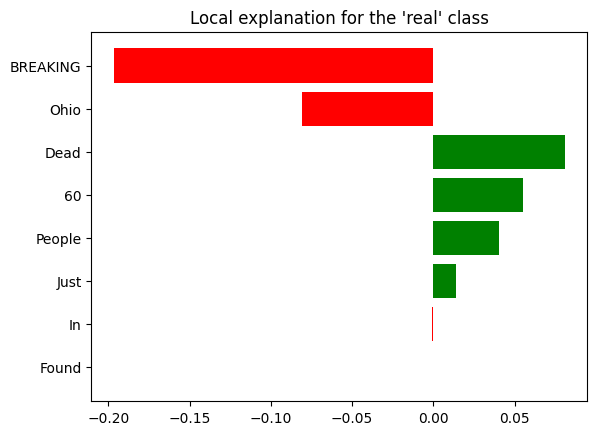

In [23]:
_ = title_explanations.as_pyplot_figure()
_ = plt.title("Local explanation for the 'real' class")

Let's do the same, but with the content model.

In [24]:
from sklearn.pipeline import make_pipeline

# Create a pipeline for the content model
content_pipeline = make_pipeline(content_vectorizer, content_mnb.mnb)
content_pipeline.predict_proba(content_test_x)

array([[0.6391448 , 0.3608552 ],
       [0.64286747, 0.35713253],
       [0.10523174, 0.89476826],
       [0.47393582, 0.52606418],
       [0.71375847, 0.28624153],
       [0.15255244, 0.84744756],
       [0.63181299, 0.36818701],
       [0.7581634 , 0.2418366 ],
       [0.63982382, 0.36017618],
       [0.2254421 , 0.7745579 ],
       [0.25261459, 0.74738541],
       [0.23709026, 0.76290974],
       [0.39442563, 0.60557437],
       [0.72784089, 0.27215911],
       [0.84575371, 0.15424629],
       [0.40973576, 0.59026424],
       [0.16459456, 0.83540544],
       [0.41604451, 0.58395549],
       [0.1226738 , 0.8773262 ],
       [0.2691765 , 0.7308235 ],
       [0.69502818, 0.30497182],
       [0.19393561, 0.80606439],
       [0.23679536, 0.76320464],
       [0.71420094, 0.28579906],
       [0.57589043, 0.42410957],
       [0.27760861, 0.72239139],
       [0.62522598, 0.37477402],
       [0.36532075, 0.63467925],
       [0.32165662, 0.67834338],
       [0.31900935, 0.68099065],
       [0.

In [25]:
document_id = 23

content_explanations = explainer.explain_instance(content_test_x.iloc[document_id], content_pipeline.predict_proba, num_features=10)

print('Content: ', content_test_x.iloc[document_id].replace('\n', '').strip())
print('Probability that the article is real =', content_pipeline.predict_proba([content_test_x.iloc[document_id]])[0, 1])
print('True class: %s' % class_names[content_test_y.iloc[document_id]])

Content:  WITH THE EUROPEAN MIGRANT CRISIS GROWING WORSE EVERY SINGLE DAY, MANY DOUBT THAT EUROPE WILL BE ABLE TO SURVIVE ITS SELF-INFLICTED IMMIGRATION WOUNDS.Some Islamic leaders have even stated that Europe will be ruled under a caliphate within the next 2 generations. While many politicians are as spineless and weak as can be, such as Merkel, Macron, and London’s Mayor, some are standing up to the atrocity that is Islamic Extremism.In an incredible turn of events, 139 out of 168 deputies voted in favor of an amendment which would allow citizens to carry guns and shoot terrorists on sight. “We do not want to disarm our own people at a time when the security situation is deteriorating,” Interior Minister Milan Chovanec said on Wednesday.Sputnik News, a news agency centered in Moscow, reports:“The new law states that Czech citizens have the right to acquire, keep and bear arms in order to ensure the security of the state.”“It means that the approximately 360,000 licensed gun-owners in

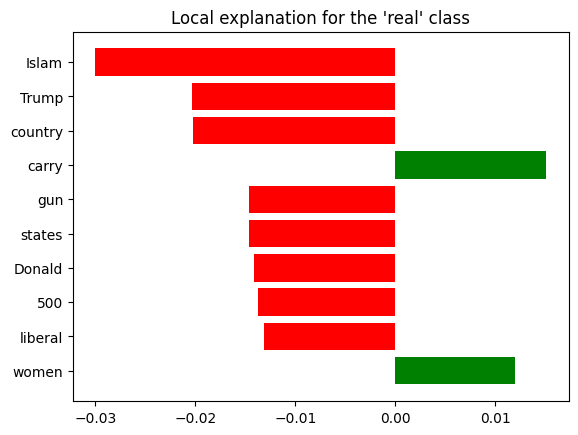

In [26]:
_ = content_explanations.as_pyplot_figure()
_ = plt.title("Local explanation for the 'real' class")

**Adequateness** 

LIME explains individual predictions by evaluating it on the model. This helps us understand which words in a news title most influenced the model's decision for that particular case. it also highlights the most influential words making it easier to understand why an article was classified as fake or real.

**Limitations** 

It's a local approach, so it doesn't tell us anything about how the model behaves across all data. 
The method may miss important interactions between features, the surrogate model only learns the marginal effect of each feature, not how groups of features might interact to influence the prediction (this is what SHAP is for). 

#### SHAP

Unfortunately I couldn't get an MNB working with the SHAP method, so I am going to use my logistic regression model to showcase this one. 

This method provides a value for each feature telling us how much it contributed (positively or negatively) to the prediction. 

Contrary to LIME, SHAP calculates feature attributions by considering all possible combinations of features, so it can capture interactions between them.

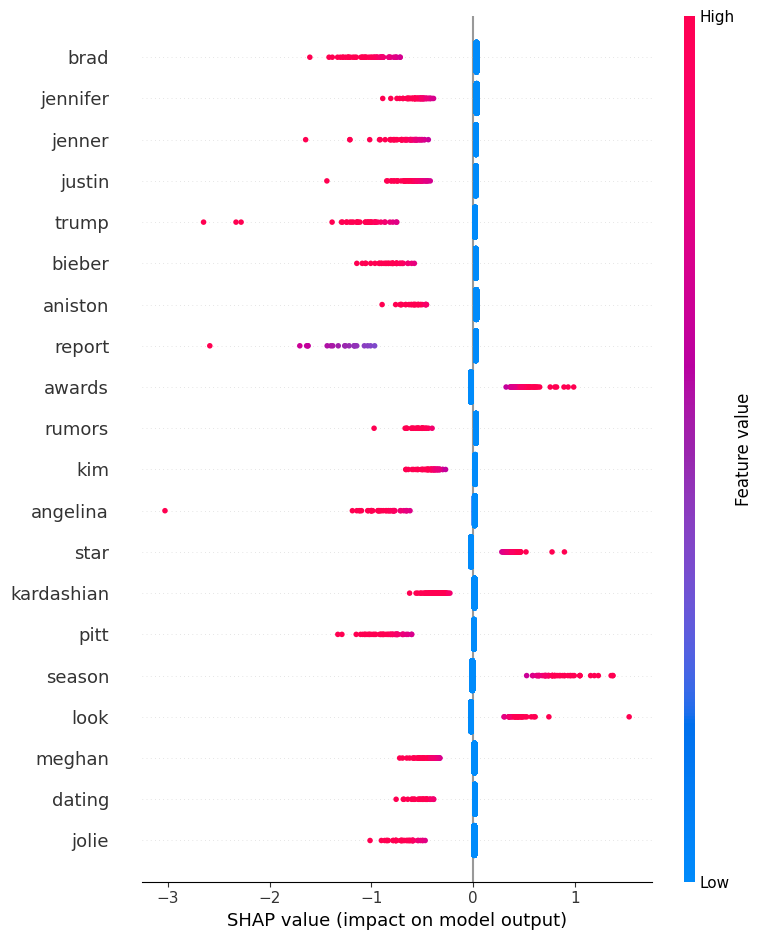

In [27]:
import shap

feature_names = title_vectorizer.get_feature_names_out()

# Use the previously trained logistic regression model
explainer = shap.LinearExplainer(regression_model, dev_x_vectorized, feature_names=feature_names)

shap_values = explainer(dev_x_vectorized.toarray())

shap.summary_plot(shap_values, dev_x_vectorized.toarray(), feature_names=feature_names)

### Global methods

#### Partial dependence plots

A partial dependence plot helps us understand the average effect of a feature on the predicted outcome of our models. For text models like our MNB models trained on TF-IDF features, we can plot a PDP for a specific word to see how the presence or absence of that word in a title/content affects the probability of predicting fake news.

Because I couldn't plot scikit-learn's partial dependence I created a simulation for creating one on our vectorized text features.

1. Choose a word which we will plot the PDP for
2. Get the feature index for the word (so we can change it's value later on)
3. Create a 2D vector with 1 element and the size of our feature count, set all elements to 0 (this simulates keeping all other values constant)
4. Loop through an interval of [0, 1] with steps of 0.1 and set the importance of our word to that value -> these produce the probability that the word contributes to being classified as real
5. Plot the probabilites

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


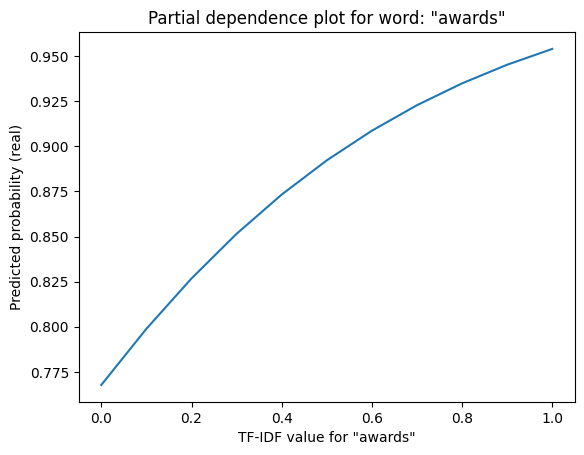

In [28]:
# Get the feature index for a chosen word
word = "awards"
feature_idx = title_vectorizer.vocabulary_[word]

# Get the number of features
feature_count = train_x_vectorized.shape[1]

# Create a two dimensional vector with 1 document and all zeros of length features [[feature1, feature2...]]
# This is the vector that will be the input of the model
base_vector = np.zeros((1, feature_count))

# Range of TF-IDF values to try
tfidf_values = np.linspace(0, 1, 11)
probabilities = []

print(tfidf_values)

# Loop through the tfidf values
for value in tfidf_values:
    test_vector = base_vector.copy()
    # Set this feature to an ever growing importance
    test_vector[0, feature_idx] = value
    probability = title_mnb.mnb.predict_proba(test_vector)[0, 1]  # Probability of 'real'
    # Save the probability
    probabilities.append(probability)

# Plot probabilities
plt.plot(tfidf_values, probabilities)
plt.xlabel(f'TF-IDF value for "{word}"')
plt.ylabel('Predicted probability (real)')
plt.title(f'Partial dependence plot for word: "{word}"')
plt.show()

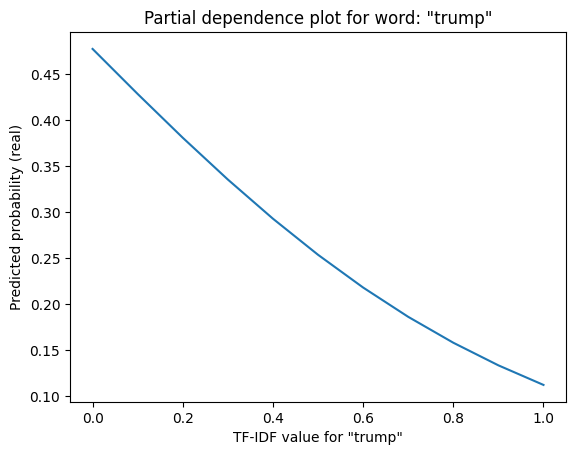

In [29]:
# Get the feature index for a chosen word
word = "trump"
feature_idx = content_vectorizer.vocabulary_[word]

# Get the number of features
feature_count = content_test_x_vectorized.shape[1]

# Create a two dimensional vector with 1 document and all zeros of length features [[feature1, feature2...]]
# This is the vector that will be the input of the model
base_vector = np.zeros((1, feature_count))

# Range of TF-IDF values to try
tfidf_values = np.linspace(0, 1, 11)
probabilities = []

# Loop through the tfidf values
for value in tfidf_values:
    test_vector = base_vector.copy()
    # Set this feature to an ever growing importance
    test_vector[0, feature_idx] = value
    probability = content_mnb.mnb.predict_proba(test_vector)[0, 1]  # Probability of 'real'
    # Save the probability
    probabilities.append(probability)

# Plot probabilities
plt.plot(tfidf_values, probabilities)
plt.xlabel(f'TF-IDF value for "{word}"')
plt.ylabel('Predicted probability (real)')
plt.title(f'Partial dependence plot for word: "{word}"')
plt.show()


**Meaning** 

These plots tell us how changing the importance of the words "award" and "trump" in an article's title and then content affect the model's confidence about whether the article is real or not. In this case our model sees that this word with growing importance will decrease the credibility of the source.  

**Adequateness** 

Since MNB is a linear model, the PDP for a single word will generally be a straight line, indicating whether the word increases or decreases the predicted probability for the class as its TF-IDF value increases.

**Limitations** 

In text classification with TF-IDF, most features are zero in most documents. In TF-IDF vectorized text data, most words are absent, 0 valued in most documents. For rare words, almost all samples have a value of zero for that feature, which could make the plot misleading or useless in the case of rare words (would appear as a flat line). 

PDPs assume the feature of interest is independent of all others, but in text, word occurrences are not independent (context matters), so the PDP will miss combinations of words that might often appear together, further reducing interpretability.

## Improving the model

#### Optimizing the alpha parameter

The alpha parameter controls Laplace smoothing, which helps the model handle words that appear in the test set but not in the training set.

A well-chosen alpha prevents zero probabilities and balances bias. Too high an alpha can oversmooth, while too low can overfit to rare words.

In [30]:
alpha_options = np.arange(0.1, 1, 0.1)
best_prediction = 0
best_alpha = 0

def calculate_accuracy_score(mnb, correct_y):
    return accuracy_score(correct_y, mnb.predictions)

for alpha in alpha_options:
    mnb = MNB(alpha)
    mnb.train_mnb(train_x_vectorized, train_y)
    mnb.evaluate_mnb(dev_x_vectorized)
    score = calculate_accuracy_score(mnb, dev_y)
    if (best_prediction < score):
        best_prediction = score
        best_alpha = alpha
        
print('Best alpha: ', best_alpha)
print('Best score: ', best_prediction)

Best alpha:  0.1
Best score:  0.8425233644859813


It seems the smaller alpha smoothing factor is, the better when we're trying to optimize for accuracy.

In [31]:
best_mnb = MNB(best_alpha)
best_mnb.train_mnb(train_x_vectorized, train_y)
best_mnb.evaluate_mnb(dev_x_vectorized)
best_mnb.calculate_classification_report(dev_y)

print("Dev set evaluation:\n", best_mnb.get_classification_report())

best_mnb.evaluate_mnb(test_x_vectorized)
best_mnb.calculate_classification_report(test_y)

print("Test set evaluation:\n", best_mnb.get_classification_report())

print("0.5 alpha model results:\n", title_mnb.get_classification_report())


Dev set evaluation:
               precision    recall  f1-score   support

        fake       0.77      0.48      0.59       505
        real       0.86      0.96      0.90      1635

    accuracy                           0.84      2140
   macro avg       0.81      0.72      0.75      2140
weighted avg       0.83      0.84      0.83      2140

Test set evaluation:
               precision    recall  f1-score   support

        fake       0.75      0.45      0.56      1013
        real       0.85      0.95      0.90      3267

    accuracy                           0.84      4280
   macro avg       0.80      0.70      0.73      4280
weighted avg       0.83      0.84      0.82      4280

0.5 alpha model results:
               precision    recall  f1-score   support

        fake       0.82      0.35      0.49       505
        real       0.83      0.98      0.90      1635

    accuracy                           0.83      2140
   macro avg       0.82      0.66      0.70      2140
weigh

On these test samples I see no obvious signs of overfitting, despite the alpha value being 0.1. This could be because the nature of news in this dataset are written in similar topics, so this might not generalize well to other types of news. 

It looks like the model has gotten overall better with higher recall and in turn better F1-scores.

#### Feature selection

Feature selection is the process of identifying and retaining only the most relevant features (words) from our dataset, removing those that are redundant or irrelevant. Fewer features mean faster training and prediction. It reduces overfitting and increases accuracy, because irrelevant features can cause the model to learn noise rather than latent patterns.  

In my case I will use the Chi-Square test to mneasure the dependence between each feature and the class label, selecting those with the highest scores and reducing the number of features.

In [32]:
import re

# Removes all digits from text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

First let's see a model trained on the content dataset.

In [33]:
from sklearn.feature_selection import SelectKBest, chi2

# Vectorize text data using TF-IDF (again, because this uses a preprocessor)
vectorizer = TfidfVectorizer(stop_words='english', preprocessor=preprocess_text)
content_train_x_vectorized = vectorizer.fit_transform(content_train_x)
content_test_x_vectorized = vectorizer.transform(content_test_x)

# Feature selection using Chi-Square test
selector = SelectKBest(chi2, k=200)  # Select top 200 features
content_train_x_selected = selector.fit_transform(content_train_x_vectorized, content_train_y)
content_test_x_selected = selector.transform(content_test_x_vectorized)

# Train Multinomial Naive Bayes with selected features
mnb = MNB(1.0)
mnb.train_mnb(content_train_x_selected, content_train_y)

# Predict and evaluate on dev set
mnb.evaluate_mnb(content_test_x_selected)
mnb.calculate_classification_report(content_test_y)

# Show results
print("Feature selected model:\n", mnb.get_classification_report())
print("Non feature selected model:\n", content_mnb.get_classification_report())

# Show selected feature names
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [vectorizer.get_feature_names_out()[i] for i in selected_feature_indices]
print("Selected features:", selected_feature_names)

Feature selected model:
               precision    recall  f1-score   support

        fake       0.82      0.93      0.87        43
        real       0.94      0.83      0.88        53

    accuracy                           0.88        96
   macro avg       0.88      0.88      0.87        96
weighted avg       0.88      0.88      0.88        96

Non feature selected model:
               precision    recall  f1-score   support

        fake       0.93      0.86      0.89        43
        real       0.89      0.94      0.92        53

    accuracy                           0.91        96
   macro avg       0.91      0.90      0.90        96
weighted avg       0.91      0.91      0.91        96

Selected features: ['actress', 'album', 'america', 'angeles', 'announced', 'ashley', 'automatically', 'available', 'avengers', 'awan', 'awards', 'baby', 'bachelor', 'bachelorette', 'bagged', 'baldwin', 'ballot', 'barack', 'belafonte', 'bell', 'bella', 'bet', 'betting', 'bieber', 'birth', 'bo

Both models perform well, but the non-feature-selected model is slightly better overall in terms of accuracy (0.91 vs 0.88).

High precision and recall for both classes show that the model can reliably distinguish between fake and real news using the article content.

Feature selection slightly reduces overall performance, possibly by removing some useful but less obvious features, but makes the model quicker to train and possibly even makes it generalize better. Also consider the fact that this new model is made using a smoothing factor of 1.0 vs 0.1 which could mean that the other model is overfit as discussed previously.

In [34]:
from sklearn.feature_selection import SelectKBest, chi2

train, test = train_test_split(original_dataset, train_size=0.8, random_state=0)
train, dev = train_test_split(train, train_size=int(len(original_dataset)*0.7), random_state=0)
train_x, train_y, test_x, test_y = train['title'], train['real'], test['title'], test['real']
dev_x, dev_y = dev['title'], dev['real']

# Vectorize text data using TF-IDF (again, because this uses a preprocessor)
vectorizer = TfidfVectorizer(stop_words='english', preprocessor=preprocess_text)
train_x_vectorized = vectorizer.fit_transform(train_x)
test_x_vectorized = vectorizer.transform(test_x)

# Feature selection using Chi-Square test
selector = SelectKBest(chi2, k=200)  # Select top 200 features
train_x_selected = selector.fit_transform(train_x_vectorized, train_y)
test_x_selected = selector.transform(test_x_vectorized)

# Train Multinomial Naive Bayes with selected features
mnb = MNB(1.0)
mnb.train_mnb(train_x_selected, train_y)

# Predict and evaluate on dev set
mnb.evaluate_mnb(test_x_selected)
mnb.calculate_classification_report(test_y)

# Show results
print("Feature selected model:\n", mnb.get_classification_report())
print("Non feature selected 'best alpha' model:\n", best_mnb.get_classification_report())

# Show selected feature names
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [vectorizer.get_feature_names_out()[i] for i in selected_feature_indices]
print("Selected features:", selected_feature_names)

Feature selected model:
               precision    recall  f1-score   support

        fake       0.88      0.11      0.20      1013
        real       0.78      1.00      0.88      3267

    accuracy                           0.79      4280
   macro avg       0.83      0.55      0.54      4280
weighted avg       0.81      0.79      0.72      4280

Non feature selected 'best alpha' model:
               precision    recall  f1-score   support

        fake       0.75      0.45      0.56      1013
        real       0.85      0.95      0.90      3267

    accuracy                           0.84      4280
   macro avg       0.80      0.70      0.73      4280
weighted avg       0.83      0.84      0.82      4280

Selected features: ['adopt', 'affleck', 'ange', 'angelina', 'aniston', 'apparently', 'awards', 'bachelor', 'bachelorette', 'ban', 'banned', 'bans', 'beckham', 'begging', 'bella', 'ben', 'bendjima', 'best', 'beyonce', 'bf', 'bieber', 'blake', 'brad', 'brangelina', 'breakdown', 'b

Fake class recall dropped from ~0.48 to 0.15, so the model is now missing most fake articles. Fake class precision increased from ~0.75 to 0.88, meaning when it does predict "fake," it's usually correct, but it almost never does.

All other stats have slightly dropped. Why?

Too aggressive feature selection.
Reducing to a small number of features (200) may have removed important signals for detecting fake news, this is true in this case because those signs are spread across too many varying features in case of only using the article title. 

The chi-square method can also be biased toward features that are more frequent, which often favors the majority class (the real class in our case).



## Discussion

#### The difference between using article title vs article content

The results demonstrate a clear improvement in model performance when using the article content as input features instead of the article title. This is not suprising since content provides much more context and detail. The body of the article contains more words, diverse vocabulary, and more opportunities for the model to detect patterns characteristic of fake or real news.

Titles are short and may often be clickbait or lack enough context for reliable classification.

Feature selection also works better with richer input. With more meaningful features from the content, statistical feature selection methods (like Chi-Square) can better identify the most discriminative words.

#### The nature of news analysis (from my experience)

An interesting of news data is that it is highly time-sensitive, which also makes it necessary to train and finetune these models frequently. In our dataset for example we can see that Brad Pitt was very popular back when these news were written, but that may not be the case now. Today's news is tomorrow's old news. I would say that either finding a way to quickly build reliable models, or using iterative models is the best way to detect fake news. Iterative models can be updated as new data arrives, ensuring that predictions remain relevant and accurate.

#### Closing remarks

During the creation of this project I have learned how to approach interpreting machine learning models. I have looked for a dataset and out of curiosity I found one on an ever-relevant topic such as fake news detection. I have organized, cleaned, imported and split my data so it could be given to a machine learning model. After that I trained multiple models (mostly multinomial naive Bayes models) and analysed their results on dev and test samples. I tried to understand my model with both local and global interpretation methods to understand which features are most influential in determining whether news is fake. I have attempted bettering my model through finding a better smoothing factor and by applying feature selection. Lastly I have learned first hand as to why we always prefer more data to less.

I sincerely hope the the notebook was clear and enjoyable to read. 

Have a nice rest of your day!